<a href="https://colab.research.google.com/github/ehddnr301/yolov3-helmet-detection/blob/master/tf1_yolo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
!pip install tensorflow-gpu==1.15.2
!pip install keras==2.3.0

     |████████████████████████████████| 411.0MB 39kB/s 
     |████████████████████████████████| 512kB 71.5MB/s 
     |████████████████████████████████| 3.8MB 56.3MB/s 
     |████████████████████████████████| 51kB 8.3MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp37-none-any.whl size=7540 sha256=0a20fb7c4c5df7053a27d48525af9b6b825e6e559d9488343b438c0a8450aa63
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.4.1 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement tensorboard~=2.4, but you'll have tensorboard 1.15.0 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement tensorflow-estimator<2.5.0,>=2.4.0, but you'll have tensorflow-estimator 1.15.1 which is incompatible.
ERROR: tensorflow-probability 0.12.1 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing instal

In [3]:
import os

os.chdir('/usr/local/lib/python3.7/dist-packages/keras/backend')

!rm -rf __init__.py
!rm -rf __pycache__
!wget https://raw.githubusercontent.com/chulminkw/DLCV/master/colab_tf115_modify_files/__init__.py

--2021-04-28 01:35:59--  https://raw.githubusercontent.com/chulminkw/DLCV/master/colab_tf115_modify_files/__init__.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6243 (6.1K) [text/plain]
Saving to: ‘__init__.py’

__init__.py         100%[===================>]   6.10K  --.-KB/s    in 0s      

2021-04-28 01:36:00 (89.3 MB/s) - ‘__init__.py’ saved [6243/6243]



In [4]:
os.chdir('/content')

In [5]:
os.getcwd()

'/content'

In [6]:
import tensorflow as tf
print(tf.__version__)

1.15.2


In [7]:
import keras
print(keras.__version__)

#### import #### 
2.3.0


Using TensorFlow backend.


In [8]:
!rm -rf '/content/gdrive/MyDrive/yolo/helmet2'

In [9]:
!unzip -n '/content/gdrive/MyDrive/yolo/VOC2028.zip' -d '/content/gdrive/MyDrive/yolo/helmet2'

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: /content/gdrive/MyDrive/yolo/helmet2/VOC2028/JPEGImages/PartA_01483.jpg  
  inflating: /content/gdrive/MyDrive/yolo/helmet2/__MACOSX/VOC2028/JPEGImages/._PartA_01483.jpg  
  inflating: /content/gdrive/MyDrive/yolo/helmet2/VOC2028/JPEGImages/hard_hat_workers4310.png  
  inflating: /content/gdrive/MyDrive/yolo/helmet2/__MACOSX/VOC2028/JPEGImages/._hard_hat_workers4310.png  
  inflating: /content/gdrive/MyDrive/yolo/helmet2/VOC2028/JPEGImages/PartA_00945.jpg  
  inflating: /content/gdrive/MyDrive/yolo/helmet2/__MACOSX/VOC2028/JPEGImages/._PartA_00945.jpg  
  inflating: /content/gdrive/MyDrive/yolo/helmet2/VOC2028/JPEGImages/hard_hat_workers1268.png  
  inflating: /content/gdrive/MyDrive/yolo/helmet2/__MACOSX/VOC2028/JPEGImages/._hard_hat_workers1268.png  
  inflating: /content/gdrive/MyDrive/yolo/helmet2/VOC2028/JPEGImages/000416.jpg  
  inflating: /content/gdrive/MyDrive/yolo/helmet2/__MACOSX/VOC2028/JPEGImages/._000416.jpg  
  inflating: 

In [10]:
# annotation과 image 디렉토리 설정. annotation디렉토리에 있는 파일 확인. 
from pathlib import Path
import glob
import xml.etree.ElementTree as ET
import tqdm

ANNO_DIR = '/content/gdrive/MyDrive/yolo/helmet2/VOC2028/Annotations/'
IMAGE_DIR = '/content/gdrive/MyDrive/yolo/helmet2/VOC2028/JPEGImages/'

files = os.listdir(ANNO_DIR)
print('파일 개수는:',len(files))

파일 개수는: 12572


In [13]:
def xml_to_csv(path, output_filename):
    xml_list = []
    
    with open(output_filename, 'w') as train_csv_file:
        for xml_file in tqdm.tqdm(glob.glob(path + '*.xml')):
            
            tree = ET.parse(xml_file)
            root = tree.getroot()

            f_name = xml_file.split('/')[8].split('.')[0]
            f_ext = 'jpg'
            if 'hard' in f_name:
              f_ext = 'png'

            full_image_name = os.path.join(IMAGE_DIR, f'{f_name}.{f_ext}')
            value_str_list = ' '
            
            for obj in root.findall('object'):

                obj_name = obj.find('name').text
                
                xmlbox = obj.find('bndbox')
                x1 = int(xmlbox.find('xmin').text)
                y1 = int(xmlbox.find('ymin').text)
                x2 = int(xmlbox.find('xmax').text)
                y2 = int(xmlbox.find('ymax').text)
                
                class_id = 0
                if obj_name == 'head' or obj_name == 'person':
                  class_id = 1

                value_str = (f'{x1},{y1},{x2},{y2},{class_id}')
                value_str_list = value_str_list + value_str + ' '

            train_csv_file.write(full_image_name + value_str_list + '\n')

In [14]:
xml_to_csv(ANNO_DIR, './train_anno.csv')

100%|██████████| 12571/12571 [00:11<00:00, 1109.29it/s]


In [15]:
!git clone https://github.com/qqwweee/keras-yolo3

Cloning into 'keras-yolo3'...
remote: Enumerating objects: 144, done.
remote: Total 144 (delta 0), reused 0 (delta 0), pack-reused 144
Receiving objects: 100% (144/144), 151.08 KiB | 1.03 MiB/s, done.
Resolving deltas: 100% (65/65), done.


In [16]:
with open('/content/keras-yolo3/model_data/helmet_classes.txt', 'w') as classes_file:
    classes_file.write('helmet\n')
    classes_file.write('head')

In [17]:
!wget https://github.com/pjreddie/darknet/blob/master/cfg/yolov3.cfg?raw=true -O ./keras-yolo3/yolov3.cfg

--2021-04-28 01:52:22--  https://github.com/pjreddie/darknet/blob/master/cfg/yolov3.cfg?raw=true
Resolving github.com (github.com)... 13.114.40.48
Connecting to github.com (github.com)|13.114.40.48|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/pjreddie/darknet/raw/master/cfg/yolov3.cfg [following]
--2021-04-28 01:52:22--  https://github.com/pjreddie/darknet/raw/master/cfg/yolov3.cfg
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg [following]
--2021-04-28 01:52:22--  https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK


In [18]:
!wget https://pjreddie.com/media/files/yolov3.weights
# !wget https://pjreddie.com/media/files/yolov3-tiny.weights

--2021-04-28 01:52:23--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  23.2MB/s    in 11s     

2021-04-28 01:52:34 (21.6 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]



In [19]:
!mv yolov3.weights ./keras-yolo3/
# !mv yolov3-tiny.weights ./keras-yolo3/

In [20]:
import numpy as np
import keras.backend as K
from keras.layers import Input, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [21]:
import sys

sys.path.insert(1, './keras-yolo3')

In [22]:

LOCAL_PACKAGE_DIR = os.path.abspath("./keras-yolo3")
sys.path.append(LOCAL_PACKAGE_DIR)

from yolo3.model import preprocess_true_boxes, yolo_body, tiny_yolo_body, yolo_loss
from yolo3.utils import get_random_data

In [23]:
# !python keras-yolo3/convert.py keras-yolo3/yolov3-tiny.cfg keras-yolo3/yolov3-tiny.weights keras-yolo3/model_data/yolo-tiny.h5
!python keras-yolo3/convert.py keras-yolo3/yolov3.cfg keras-yolo3/yolov3.weights keras-yolo3/model_data/yolo.h5

Using TensorFlow backend.
#### import #### 
Loading weights.
Weights Header:  0 2 0 [32013312]
Parsing Darknet config.
Creating Keras model.
Parsing section net_0
Parsing section convolutional_0
conv2d bn leaky (3, 3, 3, 32)
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
2021-04-28 01:52:36.929701: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-04-28 01:52:36.984340: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-04-28 01:52:36.984905: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Found device 0 with properties: 
name: Tesla P100-PCIE-16GB major: 6 minor: 0 memoryClockRate(GHz): 1.3285
pciBusID: 0000:00:04.0
2021-04-28 01:52:37.006801: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynami

In [24]:
from train import get_classes, get_anchors
from train import create_model, data_generator, data_generator_wrapper, create_tiny_model

HOME_DIR = str(Path.home())

BASE_DIR = os.path.join(HOME_DIR, 'keras-yolo3')

annotation_path = '/content/train_anno.csv'
log_dir = os.path.join(BASE_DIR, 'snapshots/000/')
classes_path = '/content/keras-yolo3/model_data/helmet_classes.txt'
anchors_path = '/content/keras-yolo3/model_data/yolo_anchors.txt'
# anchors_path = '/content/keras-yolo3/model_data/tiny_yolo_anchors.txt'

class_names = get_classes(classes_path)
num_classes = len(class_names)
anchors = get_anchors(anchors_path)

# model_weights_path = '/content/keras-yolo3/model_data/yolo-tiny.h5'
model_weights_path = '/content/keras-yolo3/model_data/yolo.h5'

input_shape = (416,416) 

is_tiny_version = len(anchors)==6 

if is_tiny_version:
    model = create_tiny_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path=model_weights_path)
else:
    model = create_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path=model_weights_path) 
    
logging = TensorBoard(log_dir=log_dir)
checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}_tiny.h5',
    monitor='val_loss', save_weights_only=True, save_best_only=True, period=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

val_split = 0.1

with open(annotation_path) as f:
    lines = f.readlines()

np.random.seed(10101)
np.random.shuffle(lines)
np.random.seed(None)
num_val = int(len(lines)*val_split)
num_train = len(lines) - num_val


if True:
    model.compile(optimizer=Adam(lr=1e-3), loss={
        'yolo_loss': lambda y_true, y_pred: y_pred})

    batch_size = 4
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
            steps_per_epoch=max(1, num_train//batch_size),
            validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
            validation_steps=max(1, num_val//batch_size),
            epochs=20,
            initial_epoch=0,
            callbacks=[logging, checkpoint])
    model.save_weights(log_dir + 'trained_weights_stage_1.h5')

if True:
    for i in range(len(model.layers)):
        model.layers[i].trainable = True
    model.compile(optimizer=Adam(lr=1e-4), loss={'yolo_loss': lambda y_true, y_pred: y_pred}) 
    print('Unfreeze all of the layers.')

    batch_size = 4 
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
        steps_per_epoch=max(1, num_train//batch_size),
        validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
        validation_steps=max(1, num_val//batch_size),
        epochs=20,
        initial_epoch=0,
        callbacks=[logging, checkpoint, reduce_lr, early_stopping])
    model.save_weights('/content/gdrive/MyDrive/yolo/yolo_trained_weights_final.h5')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Create YOLOv3 model with 9 anchors and 2 classes.


/usr/local/lib/python3.7/dist-packages/keras/engine/saving.py:1316: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((1, 1, 1024, 21) vs (255, 1024, 1, 1)).
  weight_values[i].shape))
/usr/local/lib/python3.7/dist-packages/keras/engine/saving.py:1316: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((21,) vs (255,)).
  weight_values[i].shape))
/usr/local/lib/python3.7/dist-packages/keras/engine/saving.py:1316: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((1, 1, 512, 21) vs (255, 512, 1, 1)).
  weight_values[i].shape))
/usr/local/lib/python3.7/dist-packages/keras/engine/saving.py:1316: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((21,) vs (255,)).
  weight_values[i].shape))
/usr/local/lib/python3.7/dist-packages/keras/engine/saving.py:1316: UserWarning: Skipping loading of weights for layer conv2d_75 due to mismatch in shape ((1,

Load weights /content/keras-yolo3/model_data/yolo.h5.
Freeze the first 249 layers of total 252 layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 11314 samples, val on 1257 samples, with batch size 4.



Epoch 1/20
2828/2828 [==============================] - 969s 343ms/step - loss: 112.7529 - val_loss: 53.8553

Epoch 2/20
2828/2828 [==============================] - 963s 341ms/step - loss: 57.3097 - val_loss: 53.0026
Epoch 3/20
2828/2828 [==============================] - 976s 345ms/step - loss: 52.3366 - val_loss: 65.0639
Epoch 4/20
2828/2828 [==============================] - 977s 345ms/step - loss: 50.6735 - val_loss: 39.4020
Epoch 5/20
2828/2828 [==============================] - 977s 345ms/step - loss: 49.9103 - val_loss: 48.8696
Epoch 6/20
2828/2828 [==============================] - 976s 345ms/step - loss: 49.5713 - val_loss: 46.2264
Epoch 7/20
2828/2828 [==============================] - 965s 341ms/step - loss: 49.704

In [25]:
!nvidia-smi

Wed Apr 28 12:46:35 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P0    51W / 250W |   8727MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [26]:
model.save_weights('/content/gdrive/MyDrive/yolo/yolo_trained_weights_final.h5')

In [27]:
import sys
import argparse
from yolo import YOLO, detect_video
from PIL import Image

In [29]:
helmet_yolo = YOLO(model_path='/content/gdrive/MyDrive/yolo/yolo_trained_weights_final.h5',
            anchors_path='/content/keras-yolo3/model_data/yolo_anchors.txt',
            # anchors_path='/content/keras-yolo3/model_data/tiny_yolo_anchors.txt',
            classes_path='/content/keras-yolo3/model_data/helmet_classes.txt')

/content/gdrive/MyDrive/yolo/yolo_trained_weights_final.h5 model, anchors, and classes loaded.


In [30]:
!cp -rf keras-yolo3/font ./font

['/content/gdrive/MyDrive/yolo/helmet2/VOC2028/JPEGImages/hard_hat_workers3024.png'
 '/content/gdrive/MyDrive/yolo/helmet2/VOC2028/JPEGImages/part2_001368.jpg'
 '/content/gdrive/MyDrive/yolo/helmet2/VOC2028/JPEGImages/part2_001325.jpg'
 '/content/gdrive/MyDrive/yolo/helmet2/VOC2028/JPEGImages/hard_hat_workers4599.png'
 '/content/gdrive/MyDrive/yolo/helmet2/VOC2028/JPEGImages/hard_hat_workers1682.png'
 '/content/gdrive/MyDrive/yolo/helmet2/VOC2028/JPEGImages/000105.jpg'
 '/content/gdrive/MyDrive/yolo/helmet2/VOC2028/JPEGImages/PartB_01182.jpg'
 '/content/gdrive/MyDrive/yolo/helmet2/VOC2028/JPEGImages/hard_hat_workers893.png'
 '/content/gdrive/MyDrive/yolo/helmet2/VOC2028/JPEGImages/PartB_01867.jpg'
 '/content/gdrive/MyDrive/yolo/helmet2/VOC2028/JPEGImages/001664.jpg'
 '/content/gdrive/MyDrive/yolo/helmet2/VOC2028/JPEGImages/hard_hat_workers2276.png'
 '/content/gdrive/MyDrive/yolo/helmet2/VOC2028/JPEGImages/hard_hat_workers2627.png'
 '/content/gdrive/MyDrive/yolo/helmet2/VOC2028/JPEGImag

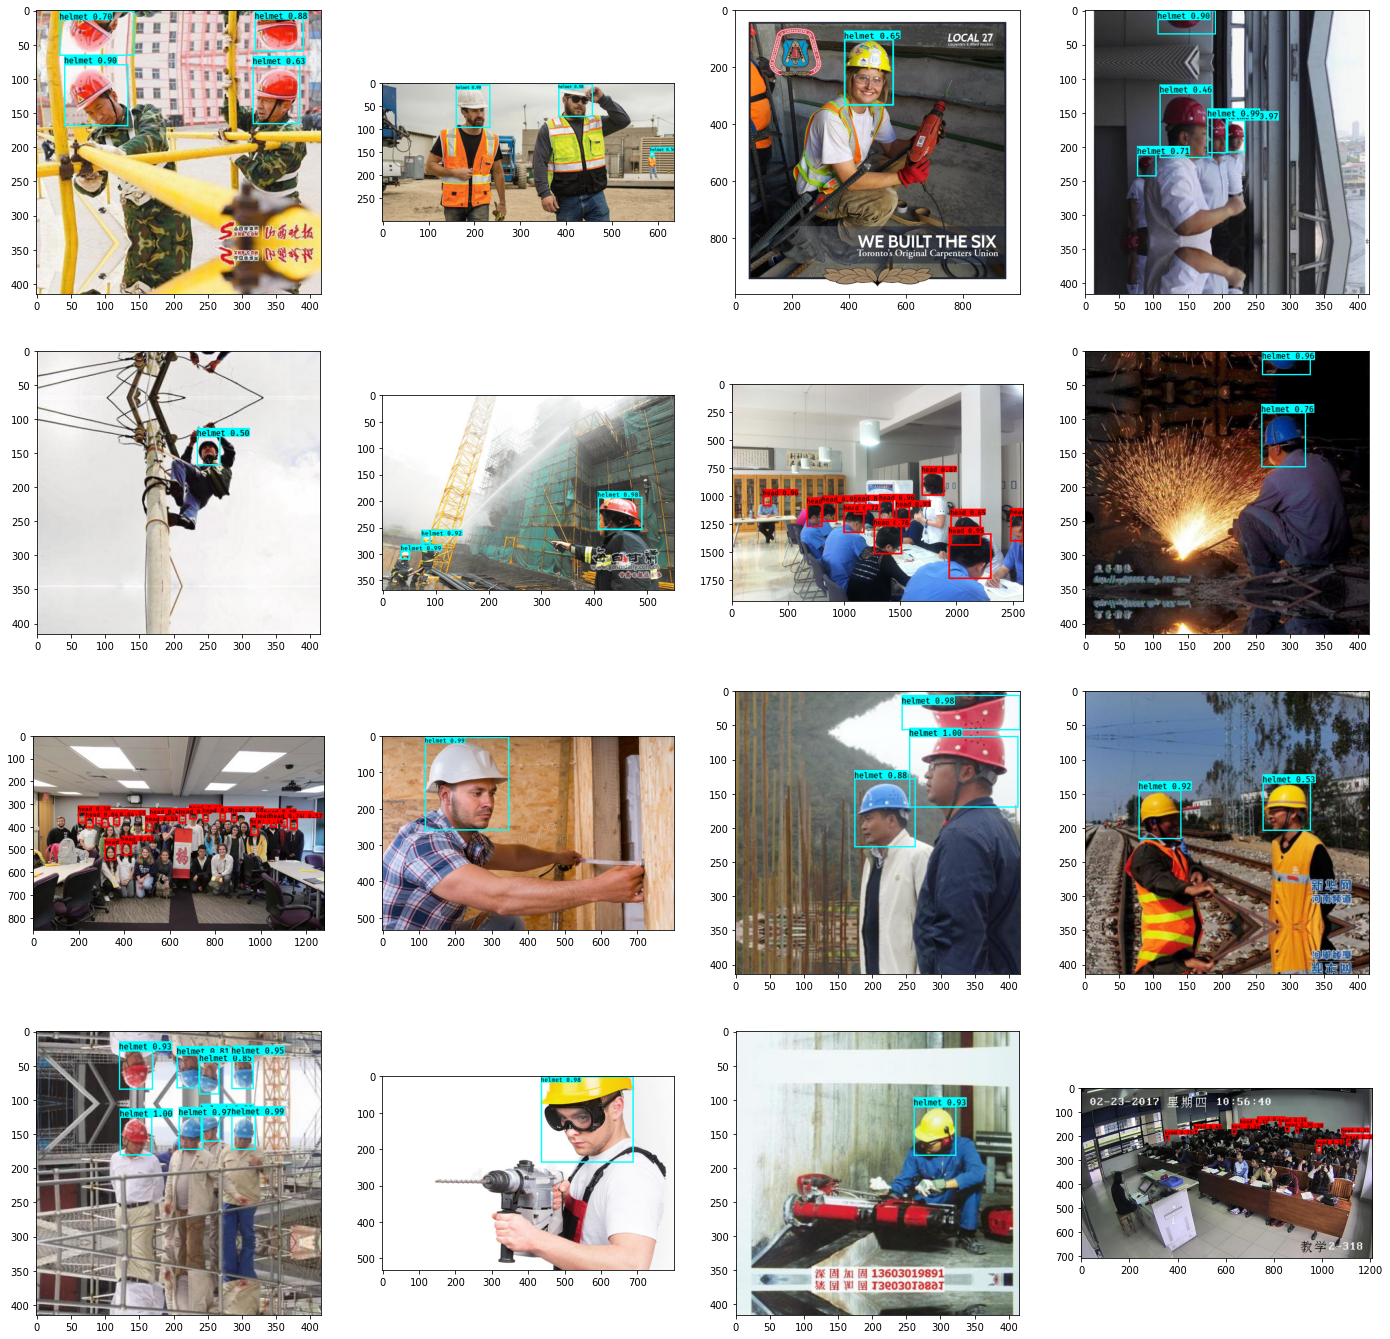

In [31]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

# 모든 이미지 파일중에서 임의의 16개 파일만 설정.
types = ('/*.png', '/*.jpg')
all_image_files = []
for files in types:
  all_image_files.extend(glob.glob(IMAGE_DIR + files))
all_image_files = np.array(all_image_files)
file_cnt = all_image_files.shape[0]
show_cnt = 16

show_indexes = np.random.choice(file_cnt, show_cnt)
show_files = all_image_files[show_indexes]
print(show_files)
fig, axs = plt.subplots(figsize=(24,24) , ncols=4 , nrows=4)

for i , filename in enumerate(show_files):
    print(filename)
    row = int(i/4)
    col = i%4
    img = Image.open(os.path.join(IMAGE_DIR, filename))
    detected_image = helmet_yolo.detect_image(img)
    axs[row][col].imshow(detected_image)

In [32]:
import cv2
import time

def detect_video_yolo(model, input_path, output_path=""):
    
    start = time.time()
    cap = cv2.VideoCapture(input_path)
    
    #codec = cv2.VideoWriter_fourcc(*'DIVX')
    codec = cv2.VideoWriter_fourcc(*'XVID')
    vid_fps = cap.get(cv2.CAP_PROP_FPS)
    vid_size = (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    vid_writer = cv2.VideoWriter(output_path, codec, vid_fps, vid_size)
    
    frame_cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print('총 Frame 갯수:', frame_cnt, '원본 영상 FPS:',vid_fps, '원본 Frame 크기:', vid_size)
    index = 0
    while True:
        hasFrame, image_frame = cap.read()
        if not hasFrame:
            print('프레임이 없거나 종료 되었습니다.')
            break
        start = time.time()
        image = Image.fromarray(image_frame)
        detected_image = model.detect_image(image)
        result = np.asarray(detected_image)
        index +=1
        print('#### frame:{0} 이미지 처리시간:{1}'.format(index, round(time.time()-start,3)))
        
        vid_writer.write(result)
    
    vid_writer.release()
    cap.release()
    print('### Video Detect 총 수행시간:', round(time.time()-start, 5))

In [34]:
detect_video_yolo(helmet_yolo, '/content/gdrive/MyDrive/yolo/hhhhh.mp4', '/content/gdrive/MyDrive/yolo/tiny_yolo_hhh.avi')

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
(416, 416, 3)
Found 0 boxes for img
0.03539782000007108
#### frame:1256 이미지 처리시간:0.036
(416, 416, 3)
Found 0 boxes for img
0.03521929000271484
#### frame:1257 이미지 처리시간:0.036
(416, 416, 3)
Found 0 boxes for img
0.03514970799733419
#### frame:1258 이미지 처리시간:0.036
(416, 416, 3)
Found 0 boxes for img
0.035877939000783954
#### frame:1259 이미지 처리시간:0.037
(416, 416, 3)
Found 0 boxes for img
0.03553486199962208
#### frame:1260 이미지 처리시간:0.036
(416, 416, 3)
Found 0 boxes for img
0.035307064004882704
#### frame:1261 이미지 처리시간:0.036
(416, 416, 3)
Found 0 boxes for img
0.03507102200092049
#### frame:1262 이미지 처리시간:0.036
(416, 416, 3)
Found 0 boxes for img
0.03484082499926444
#### frame:1263 이미지 처리시간:0.036
(416, 416, 3)
Found 0 boxes for img
0.035381103996769525
#### frame:1264 이미지 처리시간:0.036
(416, 416, 3)
Found 0 boxes for img
0.03584039099951042
#### frame:1265 이미지 처리시간:0.037
(416, 416, 3)
Found 0 boxes for img
0.03558944100223016
#### frame:1266 이미지 처리시간:0.037
(416